In [109]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [110]:
#Create functions.

#Function that creates an 'observation' of the different light curve models by taking the magnitudes 
#corresponding to 24 hour cadence starting from 0.5 days.
def make_lightcurve(t, mod):
    mag = np.zeros(len(t)) 
    for ind,i in enumerate(t):
        a = np.interp(i, model[mod][:,0], model[mod][:,1])
        mag[ind] = a
    return(mag)

#Function that scales these magnitudes with distance so that they are within a range of the expected 30% error in
#the distance parameter from the GW source.
def make_scale_model(mag, rand_dist_range):
    mag_scale=[]
    for i in range(len(rand_dist_range)):
        obs = mag + 5*np.log10((rand_dist_range[i])/(dist_all_models)) #this comes from m-M = 5log(d) - 5
        mag_scale.append(obs)
    return(mag_scale)

#Function that introduces an error of ±0.25 onto the magnitudes that would come from the optical telescope.
def introduce_telescope_err(mag_scale):
    corrected_mags = []
    rand_err = np.random.uniform(-0.25, 0.25, len(mag_scale[0]))
    for mags in mag_scale:
        corrected_mags.append(mags + rand_err) #adds same 14 errors to the 14 magnitudes of all the scaled models.
    return(corrected_mags)

#Function to create a chi squared distribution.
def make_chi_squared(mag_err, mag, cutoff_mag):
    all_chi2 = []
    for mags in mag_err:
        num = np.where(mags > cutoff_mag)[0]
        if len(num) > 10:
            chi2 = max_chi2_val
        else:
            remove_ind = np.logical_not(mags>cutoff_mag)
            mags = mags[remove_ind] #remove elements that have a magnitude greater than cutoff mag.
            kn = mag[0][remove_ind] #removes elements from reference magnitues so arrays are equal sizes.
            chi2 = np.sum(np.square(mags - kn)/kn)
        all_chi2.append(chi2)
    return(all_chi2)

#Function to return a dictionary with the minimmum chi value and the model related to this minimum chi value.
def return_best_model(dictionary):
    min_chi2_models = np.ones(len(dictionary)) #creates an array of ones with the length of the dict.
    for i in range(0,len(dictionary)):
        min_chi2_models[i] = min(dictionary[str(i)]) #appends values of dictionary (in string form) to ones array.
    val = min_chi2_models.min() #finds the minimum chisquared value in the model.
    ind = min_chi2_models.argmin() #finds the model where this lowest value lies.
    return(val, ind)

#Function that provides the necessary parameters to plot the individual efficiency curve for a certain model.
def plot_seperate_efficiency_curves(mod, kn_mod, best_fit, chi2, kn_dist, mod_dist, match, non_match):
    kn_ind = np.where(kn_mod==mod)[0] #finds the indicies where the kn model is model i (i.e. 0 and then 1, ect.)
    best_ind = best_fit[kn_ind] #puts these indicies into the best fit model to find whether the theoretical and 
                                #best fit models are the same at the same index point.
    chi2_ind = chi2[kn_ind]
    
    match_dist = np.zeros(len(kn_ind))
    alt_match_dist = np.zeros(len(kn_ind))
    cumulative = np.zeros(len(kn_ind))
    
    for j in range(0,len(kn_ind)):
        match_dist[j] = kn_dist[kn_ind[j]] 
        alt_match_dist[j] = mod_dist[kn_ind[j]]
        if best_ind[j] == mod and chi2_ind[j] != max_chi2_val:                                              
            cumulative[j] = match       
        else:
            cumulative[j] = non_match
            
    plot_dist = np.sort(match_dist)
    alt_plot_dist = np.sort(alt_match_dist)
    plot_cumulative = np.sort(cumulative)
    
    error_dist = plot_dist - alt_plot_dist
    cumsum = np.cumsum(plot_cumulative)[::-1]
    norm_cumsum = (cumsum / (len(cumsum))*100)
    return(plot_dist, norm_cumsum, error_dist)

In [111]:
#Load in models.

lc = np.load('light_curves.npz')
m0 = lc['two']
m1 = lc['two_r']
m2 = lc['two_b']
m3 = lc['three']
m4 = lc['three_b']
m5 = lc['KW']
m6 = lc['BR']
m7 = lc['GW']

#Define parameters.

N = 10000 #number of kn models in Universe.

model = [m0, m1, m2, m3, m4, m5, m6, m7] #array of all the kn models.
time = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5] #cadence of the observations in days.

dist = np.random.uniform(40,200,N) #Mpc #creates random distance between 40-200 Mpc (range we expect to detect KN).
dist_all_models = 40 #Mpc #reference distance when scaling the magnitudes.
low_dist_err = 0.7 #min distance from the 30% error range.
high_dist_err = 1.3 #max distance from the 30% error range.

cutoff_mag = 21 #GOTO will not be able to observe anything beyond (fainter) this magnitude.
max_chi2_val = 10000

#Conditions for a match to use in the cumulative sum.
match = 1 
non_match = 0

In [112]:
#Simulating N kilonova models in the universe.

#List of empty arrays used to append values in the loop.
array_kns = []
all_kn_distance = []
model_distance = []
min_chi2 = []
best_model = []
ind_chi2 = []
dist_ind_value = []

for j in range(N):
    
    #Create kn in universe.
    
    x = np.random.randint(0, 8) #chooses a random model out of the 8.
    gen_kn = make_lightcurve(time, x) #universe creates 'observation' of model with magnitudes taken at cadences.
    kn = make_scale_model(gen_kn, [dist[j]]) #places this observation model at a random distance.
    
    #Record model of kn chosen to store in dictionary later.
    array_kns.append(x)
    
    #Work out step of model over distance to give a range between min and max 30% error range.
    dist_range = np.arange(np.floor(low_dist_err*dist[j]), np.ceil(high_dist_err*dist[j]), 1)
    
    #Use functions defined and loop them over all models.
    chisquare_models = []
    for i in range(len(model)):
        magnitude = make_lightcurve(time, i) #inserting model number from 0-7 (models 1-8) and times for cadenece.
        scale = make_scale_model(magnitude, dist_range) #inserting the returned 'mag' from previous magnitude                                                
                                                        #function and the distance range to scale models over.
        error = introduce_telescope_err(scale) #inserting the scaled magnitudes from the scale function.
        chisquare = make_chi_squared(error, kn, cutoff_mag) #inserting the corrected magnitudes and the magnitudes
                                                            #from the original kn model.
        chisquare_models.append(chisquare) #appending the chisquare values for each of the 8 models.
        
    #Save chisquared data for each model in a dictionary.
    chi_dict = {'0':chisquare_models[0], '1':chisquare_models[1], '2':chisquare_models[2], '3':chisquare_models[3], '4':chisquare_models[4], '5':chisquare_models[5], '6':chisquare_models[6], '7':chisquare_models[7]}
    #Using return best model function to find min chi and best model fit for all the models over every iteration.
    return_best_model(chi_dict)
    lowest_chi = return_best_model(chi_dict)[0]
    related_model = return_best_model(chi_dict)[1]
    min_chi2.append(lowest_chi)
    best_model.append(related_model)
    
    #Finding the index of the minimum chi value to find out where the distance of the model is.
    chi_index_min = np.argmin(chisquare_models[int(related_model)]) #finds index of min chisquare value in models.
    ind_chi2.append(chi_index_min)
    dist_range_index = dist_range[int(chi_index_min)] #puts index of min chi into distance to get a value.
    dist_ind_value.append(dist_range_index)
    
    #Looping over dist_all_models N times for kn_info dict.
    all_kn_distance.append(int(dist[j]))

In [113]:
#Save KN, best fit model, min chi2 value, model distance (use indexing to find lowest) and KN distance)

kn_info = {'KN model':array_kns, 'Best fit model':best_model, 'Minimum Chi2':min_chi2, 'Model distance':dist_ind_value, 'KN distance':all_kn_distance}

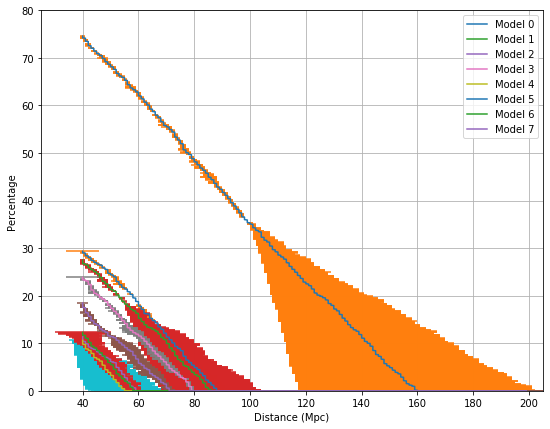

In [114]:
#Create an efficiency curve.

#Turning arrays into numpy arrays.
kn_mod = kn_info['KN model']
best_fit = kn_info['Best fit model']
kn_dist = kn_info['KN distance']
chi2 = kn_info['Minimum Chi2']
mod_dist = kn_info['Model distance']
    
kn_mod = np.asarray(kn_mod)
best_fit = np.asarray(best_fit)
kn_dist = np.asarray(kn_dist)
chi2 = np.asarray(chi2)
mod_dist = np.asarray(mod_dist)

plt.figure(figsize=(9,7))
plt.grid()

for i in range(0,len(model)):
    kn_ind = np.where(kn_mod==i)[0] #finds the indicies where the kn model is model i (i.e. 0 and then 1, ect.)
    best_ind = best_fit[kn_ind] #puts these indicies into the best fit model to find whether the theoretical and 
                                #best fit models are the same at the same index point.
    
    chi2_ind = chi2[kn_ind]
    match_dist = np.zeros(len(kn_ind))
    alt_match_dist = np.zeros(len(kn_ind))
    cumulative = np.zeros(len(kn_ind))
    
    for j in range(0,len(kn_ind)):
        match_dist[j] = kn_dist[kn_ind[j]] #appends kn distance of relating KN model to an array.
        alt_match_dist[j] = mod_dist[kn_ind[j]] #appends mod distance of relating KN model to array for error calc.
        if best_ind[j] == i and chi2_ind[j] != max_chi2_val: #if value of best fit model is same as value of kn ind
                                                             #then match and add 1.
            cumulative[j] = match       
        else: #if value of best fit model is not the same as value of kn ind then non-match and add nothing.
            cumulative[j] = non_match

    plot_dist = np.sort(match_dist) #orders distances.
    alt_plot_dist = np.sort(alt_match_dist)
    plot_cumulative = np.sort(cumulative)
    
    error_dist = plot_dist - alt_plot_dist #calculates error between two model distances.
    cumsum = np.cumsum(plot_cumulative)[::-1]
    norm_cumsum = (cumsum / (len(cumsum))*100) #normalises the cumulative sum to be represented in percentage form.
    
    label = 'Model %s' % i #label different model numbers.
    plt.plot(plot_dist, norm_cumsum, label=label)
    plt.errorbar(plot_dist, norm_cumsum, xerr=error_dist, linestyle="None")
    plt.legend()
    plt.ylabel('Percentage')
    plt.xlabel('Distance (Mpc)')
    plt.xlim(25,205)
    plt.ylim(0,80)

(0, 32)

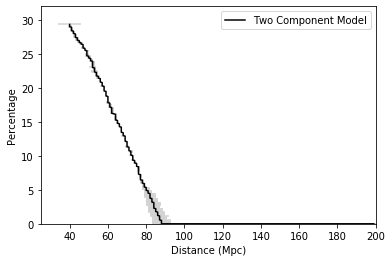

In [115]:
eff_curve = plot_seperate_efficiency_curves(0, kn_mod, best_fit, chi2, kn_dist, mod_dist, match, non_match)
label = 'Two Component Model'
plt.plot(eff_curve[0], eff_curve[1], label=label, color='black')
plt.errorbar(eff_curve[0], eff_curve[1], xerr=eff_curve[2], linestyle="None", ecolor='lightgrey')
plt.legend()
plt.ylabel('Percentage')
plt.xlabel('Distance (Mpc)')
plt.xlim(25,200)
plt.ylim(0,32)

(0, 30)

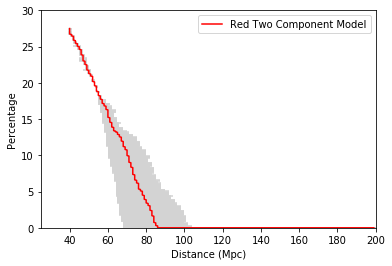

In [116]:
eff_curve = plot_seperate_efficiency_curves(1, kn_mod, best_fit, chi2, kn_dist, mod_dist, match, non_match)
label = 'Red Two Component Model'
plt.plot(eff_curve[0], eff_curve[1], label=label, color='red')
plt.errorbar(eff_curve[0], eff_curve[1], xerr=eff_curve[2], linestyle="None", ecolor='lightgrey')
plt.legend()
plt.ylabel('Percentage')
plt.xlabel('Distance (Mpc)')
plt.xlim(25,200)
plt.ylim(0,30)

(0, 12)

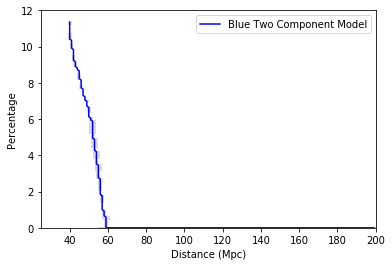

In [117]:
eff_curve = plot_seperate_efficiency_curves(2, kn_mod, best_fit, chi2, kn_dist, mod_dist, match, non_match)
label = 'Blue Two Component Model'
plt.plot(eff_curve[0], eff_curve[1], label=label, color='blue')
plt.errorbar(eff_curve[0], eff_curve[1], xerr=eff_curve[2], linestyle="None", ecolor='lightgrey')
plt.legend()
plt.ylabel('Percentage')
plt.xlabel('Distance (Mpc)')
plt.xlim(25,200)
plt.ylim(0,12)

(0, 27)

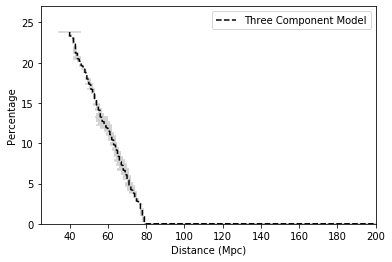

In [118]:
eff_curve = plot_seperate_efficiency_curves(3, kn_mod, best_fit, chi2, kn_dist, mod_dist, match, non_match)
label = 'Three Component Model'
plt.plot(eff_curve[0], eff_curve[1], label=label, linestyle='--', color='black')
plt.errorbar(eff_curve[0], eff_curve[1], xerr=eff_curve[2], linestyle="None", ecolor='lightgrey')
plt.legend()
plt.ylabel('Percentage')
plt.xlabel('Distance (Mpc)')
plt.xlim(25,200)
plt.ylim(0,27)

(0, 11)

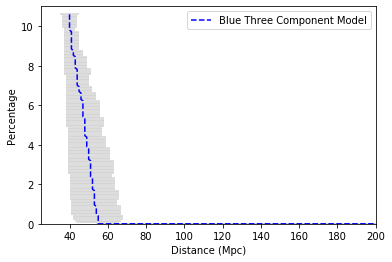

In [125]:
eff_curve = plot_seperate_efficiency_curves(4, kn_mod, best_fit, chi2, kn_dist, mod_dist, match, non_match)
label = 'Blue Three Component Model'
plt.plot(eff_curve[0], eff_curve[1], label=label, linestyle='--', color='blue')
plt.errorbar(eff_curve[0], eff_curve[1], xerr=eff_curve[2], linestyle="None", ecolor='lightgrey')
plt.legend()
plt.ylabel('Percentage')
plt.xlabel('Distance (Mpc)')
plt.xlim(25,200)
plt.ylim(0,11)

(0, 80)

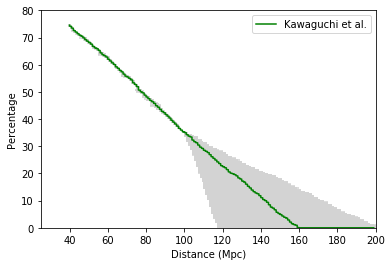

In [120]:
eff_curve = plot_seperate_efficiency_curves(5, kn_mod, best_fit, chi2, kn_dist, mod_dist, match, non_match)
label = 'Kawaguchi et al.'
plt.plot(eff_curve[0], eff_curve[1], label=label, color='green')
plt.errorbar(eff_curve[0], eff_curve[1], xerr=eff_curve[2], linestyle="None", ecolor='lightgrey')
plt.legend()
plt.ylabel('Percentage')
plt.xlabel('Distance (Mpc)')
plt.xlim(25,200)
plt.ylim(0,80)

(0, 14)

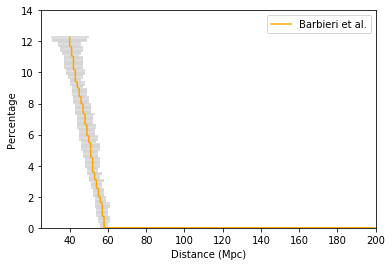

In [121]:
eff_curve = plot_seperate_efficiency_curves(6, kn_mod, best_fit, chi2, kn_dist, mod_dist, match, non_match)
label = 'Barbieri et al.'
plt.plot(eff_curve[0], eff_curve[1], label=label, color='orange')
plt.errorbar(eff_curve[0], eff_curve[1], xerr=eff_curve[2], linestyle="None", ecolor='lightgrey')
plt.legend()
plt.ylabel('Percentage')
plt.xlabel('Distance (Mpc)')
plt.xlim(25,200)
plt.ylim(0,14)

(0, 23)

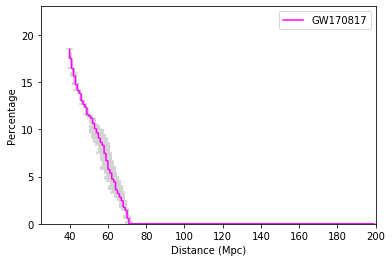

In [122]:
eff_curve = plot_seperate_efficiency_curves(7, kn_mod, best_fit, chi2, kn_dist, mod_dist, match, non_match)
label = 'GW170817'
plt.plot(eff_curve[0], eff_curve[1], label=label, color='fuchsia')
plt.errorbar(eff_curve[0], eff_curve[1], xerr=eff_curve[2], linestyle="None", ecolor='lightgrey')
plt.legend()
plt.ylabel('Percentage')
plt.xlabel('Distance (Mpc)')
plt.xlim(25,200)
plt.ylim(0,23)